In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax 
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import trange

# from model import SetTransformer
from model import MultiheadAttentionBlock, MultiheadAttentionPooling, SelfAttentionBlock, Encoder, Decoder

key = jr.key(0)

In [2]:
def image_to_point_cloud(
    img,
    Npix=28,                # size of image
    Nextra=3,               # number of extra points to add
    noise_scale=0.5,        # Units of pixels
    plot=False,
    n_points_subsample=400, # Number of total points to subsample
):
    """ Convert image tensor to point cloud """
    rotation = np.array([[0.0, -1.0], [1.0, 0.0]]) # 90 deg rotation

    def pixel_to_coords(i, j, Nextra=Nextra):
        pixel_points = []

        # cartesian coordinates of pixel
        x = i 
        y = j

        # perturb position of point so img doesn't look gridded
        point = np.array([x, y])
        pixel_point = point + np.random.normal(loc=0.0, scale=noise_scale, size=(2,))

        pixel_points.append(pixel_point)

        # add some extra points for each pixel
        for i in range(Nextra):
            pixel_points.append(
                # add a few noisy points around the given point
                point + np.random.normal(loc=0.0, scale=noise_scale, size=(2,))
            )
        return pixel_points

    points = []  # (x, y) coordinates
    density = [] # pixel values
    for i in range(Npix):
        for j in range(Npix):
            # skip the empty pixels
            if img[i, j] == 0.:
                continue
            else:
                # make the (x,y) points for each pixel
                points.append(pixel_to_coords(i, j))
                # copy the pixel value accordingly
                density.extend([img[i, j]] * (Nextra + 1))

    density = np.asarray(density)
    points = np.asarray(points).reshape(-1, 2)
    points = np.matmul(points, rotation)

    # Scale points to [-1, 1]
    points = 2. * (points - points.min(axis=0)) / (points.max(axis=0) - points.min(axis=0)) - 1.

    if n_points_subsample is not None:
        idx = np.random.randint(0, len(points), size=(n_points_subsample,))
        points = points[idx]
        density = density[idx]

    return points, density

In [3]:
dataset = torchvision.datasets.MNIST(
    root="~/MNIST",
    download=True,
    transform=torchvision.transforms.ToTensor()
)

n_data = 1_000 # Max = 60,000
use_density = True # Use pixel density information or not

# Probably a faster way of doing this but sets can be difficult
mnist_clouds = []
labels = []
idx = np.random.randint(0, len(dataset), (n_data,))
for i in trange(n_data):
    image, y = dataset[idx[i]]

    points, density = image_to_point_cloud(
        image.numpy().squeeze(), # Remove channel --> numpy array
        plot=i == (n_data - 1), 
        noise_scale=0.1,
        n_points_subsample=200
    )

    # Record the (x, y) points and the pixel density, plus label
    mnist_clouds.append(
        np.concatenate([points, density[:, np.newaxis]], axis=1)
        if use_density else points
    )
    labels.append(y) # Do this on the side to avoid type casting

  0%|          | 0/1000 [00:00<?, ?it/s]

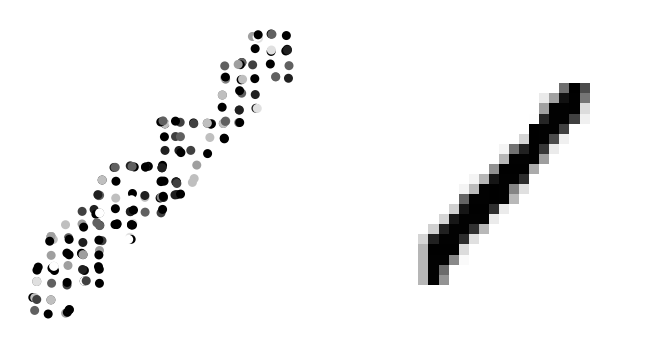

In [26]:
ix = np.random.randint(0, n_data)

cmap = "gray_r"
fig, ax = plt.subplots(1, 2, figsize=(4., 2.), dpi=200)
ax[0].scatter(*mnist_clouds[ix][:, :2].T, c=density, s=5.0, cmap=cmap)
ax[1].axis("off")
ax[1].imshow(dataset[idx[ix]][0].squeeze(), cmap=cmap)
ax[0].axis("off")
plt.show()

In [5]:
# Stack as arrays, assuming sets of equal cardinality here
X = np.stack(mnist_clouds)
Y = np.stack(labels) # Optax wants integers for loss

X = (X - X.mean(axis=0)) / X.std(axis=0)

X.shape, Y.shape

((1000, 200, 3), (1000,))

In [6]:
f = 0.8
Xt, Xv = np.split(X, [int(f * len(X))])
Yt, Yv = np.split(Y, [int(f * len(X))])

set_ds_train = torch.utils.data.TensorDataset(torch.as_tensor(Xt), torch.as_tensor(Yt))
set_ds_valid = torch.utils.data.TensorDataset(torch.as_tensor(Xv), torch.as_tensor(Yv))

In [7]:
from typing import Optional
from jaxtyping import Key, Array


class SetTransformer(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    # mlp: eqx.nn.MLP
    embedder: Optional[eqx.Module] = None

    def __init__(
        self, 
        data_dim: int, 
        out_dim: int, 
        n_layers: int, 
        n_heads: int, 
        n_seeds: int, 
        hidden_dim: int, 
        embed_dim: int, 
        *, 
        key: Key
    ):
        keys = jr.split(key, 4)
        input_dim = embed_dim if embed_dim is not None else data_dim
        self.encoder = Encoder(
            input_dim,
            hidden_dim,
            n_layers, 
            n_heads, 
            hidden_dim, 
            key=keys[0]
        )
        self.decoder = Decoder(
            hidden_dim,
            out_dim,
            n_layers,
            n_heads, 
            n_seeds, 
            hidden_dim, 
            key=keys[1]
        )
        # self.mlp = eqx.nn.MLP(
        #     , 
        #     out_dim, 
        #     width_size=hidden_dim, 
        #     depth=1, 
        #     activation=jax.nn.gelu,
        #     key=keys[2]
        # )
        if embed_dim is not None:
            self.embedder = eqx.nn.Linear(data_dim, embed_dim, key=keys[3])
    
    def __call__(self, x: Array) -> Array:
        if self.embedder is not None:
            x = jax.vmap(self.embedder)(x)
        z = self.encoder(x)
        y = self.decoder(z) # No encoder here?! it is within PMA that is within 
        # print("y", y.shape)
        return y #jax.vmap(self.mlp)(y) # This right?, this array always the same shape

In [8]:
n_data, n_set, data_dim = X.shape

model = SetTransformer(
    data_dim, 
    out_dim=10, # MNIST
    n_layers=2, 
    n_heads=4, # Divisible by data_dim?
    n_seeds=1, # This is basically num_seeds in original implementations?
    hidden_dim=64,
    embed_dim=None,
    key=key
)

jax.vmap(model)(jnp.ones((5, 10, 3))).shape
# model(jnp.ones((10, 3))).shape

(5, 1, 10)

In [9]:
n_epochs = 100
n_batch = 512
opt = optax.adam(learning_rate=1e-4)

n_data, n_set, data_dim = X.shape

model = SetTransformer(
    data_dim, 
    out_dim=10, # MNIST
    n_layers=2, 
    n_heads=2, # Divisible by data_dim?
    n_seeds=1, 
    hidden_dim=64,
    embed_dim=None,
    key=key
)

opt_state = opt.init(eqx.filter(model, eqx.is_array))


def loss(model, x, y):
    y_ = jax.vmap(model)(x).squeeze()
    return optax.softmax_cross_entropy_with_integer_labels(y_, y).mean()


@eqx.filter_jit
def make_step(model, opt_state, x, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def eval(model, x, y):
    loss_value = loss(model, x, y)
    return loss_value


def prepare(x, y):
    return x.numpy(), y.numpy()


losses = []
with trange(n_epochs) as bar:
    set_dl_train = torch.utils.data.DataLoader(set_ds_train, batch_size=n_batch)
    set_dl_valid = torch.utils.data.DataLoader(set_ds_valid, batch_size=n_batch)

    for _ in bar:
        Lt = 0.
        for t, (x, y) in enumerate(set_dl_train):
            x, y = prepare(x, y)
            model, opt_state, _Lt = make_step(model, opt_state, x, y)
            Lt += _Lt

        Lv = 0.
        for v, (x, y) in enumerate(set_dl_valid):
            x, y = prepare(x, y)
            _Lv = eval(model, x, y)
            Lv += _Lv

        losses.append((Lt.item() / (t + 1), Lv.item() / (v + 1)))
        bar.set_postfix_str(f"{Lt=:.3E} {Lv=:.3E}")

  0%|          | 0/100 [00:00<?, ?it/s]

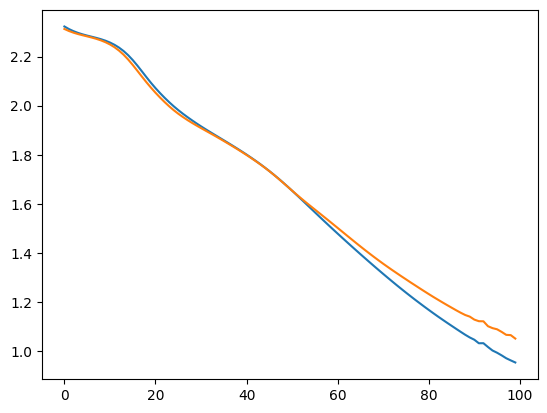

In [10]:
plt.plot(losses)
plt.show()

In [11]:
@eqx.filter_jit
def compute_accuracy(model, x, y):
    pred_y = jax.vmap(model)(x).squeeze()
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)


avg_loss = 0
avg_acc = 0
for i in range(100):
    ix = jr.randint(jr.fold_in(key, i), (n_batch,), 0, n_data)
    x, y = X[ix], Y[ix]

    avg_loss += loss(model, x, y)
    avg_acc += compute_accuracy(model, x, y)

n_test = (i + 1) * n_batch
print(avg_loss / n_test, avg_acc / n_test)

0.0018971259 0.0014743042


/Users/Jed.Homer/phd/random/vit_basic/vit/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


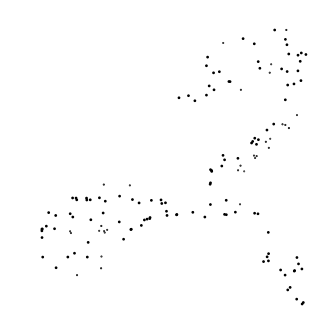

(0, 2)

In [12]:
ix = np.random.randint(0, n_data)

plt.figure(figsize=(4., 4.))
plt.scatter(*X[ix].T, color="k")
plt.axis("off")
plt.show()

jnp.argmax(model(X[ix])).item(), Y[ix].item()

TypeError: Axes.scatter() got multiple values for argument 's'

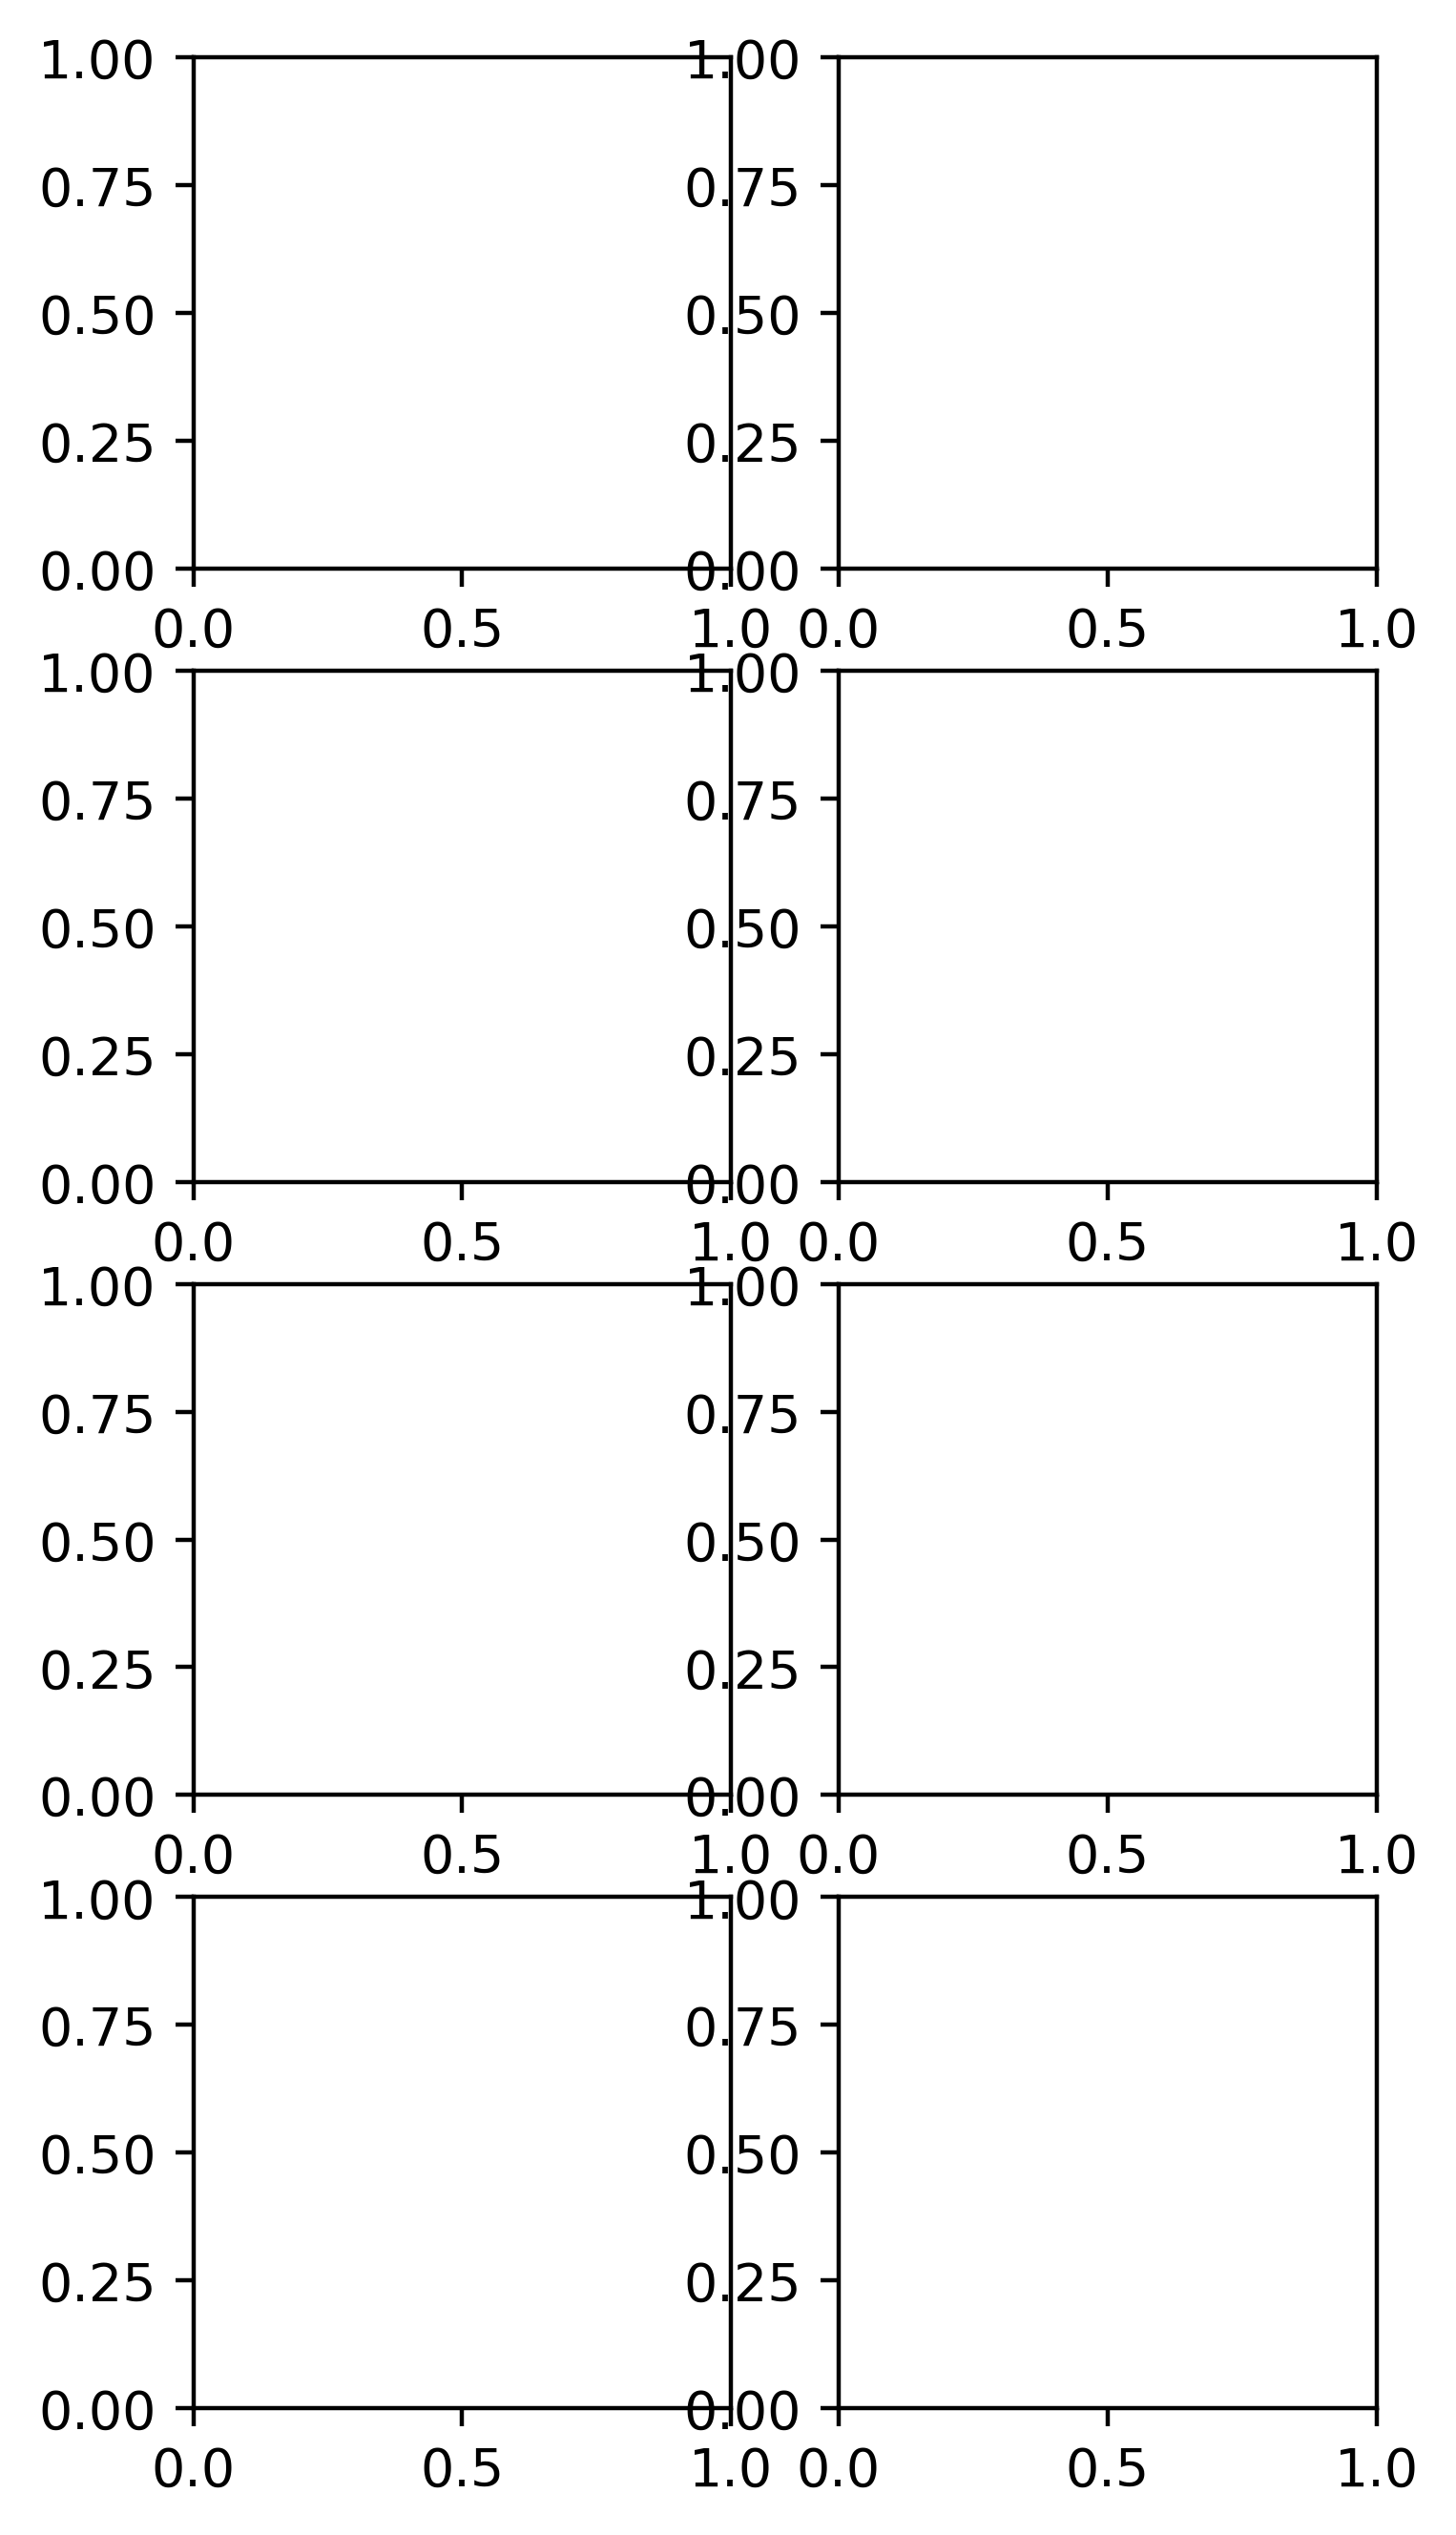

In [13]:
n_plot = 4

cmap = "gray_r"
fig, axs = plt.subplots(n_plot, 2, figsize=(4., 2. * n_plot), dpi=400)
for n in range(n_plot):
    i = np.random.randint(0, n_data)
    ax = axs[n, :]
    ax[0].scatter(*mnist_clouds[i].T, c=density, s=1.0, cmap=cmap)
    l = 1.5
    ax[0].set_xlim(-l, l)
    ax[0].set_ylim(-l, l)
    ax[1].axis("off")
    ax[1].imshow(dataset[i][0].squeeze(), cmap=cmap)
    ax[0].axis("off")
plt.savefig("../figs/data.png", bbox_inches="tight")
plt.close()